# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import nltk
# nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

In [2]:
import pandas as pd
import re
import numpy as np

from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB

In [3]:
def get_score(test_y, pred_y):
    f1 =[]
    for i in range(test_y.shape[1]):
        print('################   ' + test_y.columns[i] + '   ##################')
        print(classification_report(test_y.iloc[:,i], pred_y[:,i]))
        f1.append(f1_score(test_y.iloc[:,i], pred_y[:,i], average='micro'))
        
    print("The Mean score of F1 is: {}".format(pd.Series(f1).mean()))
    
    return pd.Series(f1).mean()

In [4]:
!ls ../data

DisasterResponse.db     disaster_messages.csv
disaster_categories.csv process_data.py


In [5]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df = pd.read_sql_table('data/DisasterResponse.db', con=engine)

X = df["message"]
Y = df[['related', 'request',
       'offer', 'aid_related', 'medical_help', 'medical_products',
       'search_and_rescue', 'security', 'military', 'child_alone', 'water',
       'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees',
       'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report']]

In [6]:
print(X.shape)
print(Y.shape)

(26216,)
(26216, 36)


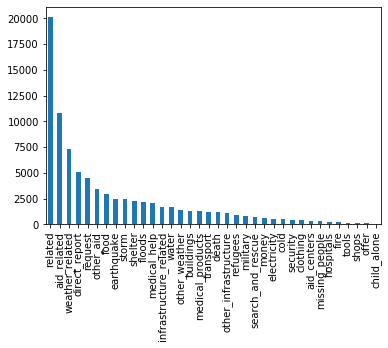

In [15]:
df[['related', 'request',
       'offer', 'aid_related', 'medical_help', 'medical_products',
       'search_and_rescue', 'security', 'military', 'child_alone', 'water',
       'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees',
       'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report']].sum().sort_values(ascending=False).plot(kind='bar')

In [44]:
tok = df["message"].apply(tokenize)

In [58]:
vectorizer = CountVectorizer(tokenizer=tokenize)
vc

['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti']

In [83]:
vc.get_feature_names()

['0',
 '00',
 '000',
 '0000',
 '000gdes',
 '000ha',
 '000l',
 '000lt',
 '000ltrs',
 '000m',
 '000rmb',
 '000rs',
 '000s',
 '00bearthquake',
 '00e',
 '00g',
 '00gd',
 '00gdes',
 '00goud',
 '00gourdes',
 '00h',
 '00htg',
 '00k',
 '00kg',
 '00khandan',
 '00klms',
 '00km',
 '00m',
 '00million',
 '00mm',
 '00mt',
 '00s',
 '00us',
 '00x',
 '00yrs',
 '0a',
 '0am',
 '0are',
 '0b',
 '0ba',
 '0bm',
 '0c',
 '0cf',
 '0chipotle',
 '0cm',
 '0e',
 '0f',
 '0feet',
 '0ft',
 '0fwse',
 '0gar',
 '0gd',
 '0gdes',
 '0goud',
 '0gourdes',
 '0h',
 '0houses',
 '0hxrc',
 '0k',
 '0kg',
 '0kgs',
 '0km',
 '0kmph',
 '0kva',
 '0l',
 '0ltrs',
 '0m',
 '0mil',
 '0million',
 '0mins',
 '0ml',
 '0mm',
 '0mph',
 '0mt',
 '0nwa0rb',
 '0oxgs',
 '0pm',
 '0ppm',
 '0report',
 '0skatepark',
 '0sqkm',
 '0th',
 '0thcentury',
 '0thousand',
 '0tit',
 '0tranbleman',
 '0veupw',
 '0vocb',
 '0wbiqkj',
 '0x',
 'aa',
 'aaa',
 'aaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

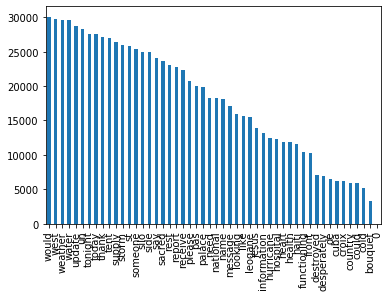

In [87]:
pd.Series(vc.vocabulary_).head(50).sort_values(ascending=False).plot(kind='bar')

In [40]:
nltk.FreqDist(test)

FreqDist({})

### 2. Write a tokenization function to process your text data

In [28]:
def tokenize(text):
    
    # 1. Normalize
    text = text.lower()
    
    # 2. Punctuation Removal
    text = re.sub(r"[^a-zA-Z0-0]", " ", text)
    
    # 3. Tokenization
    tokens = word_tokenize(text)
    
    # 4. Stopword Removal
    tokens_without_stop = [w for w in tokens if w not in stopwords.words("english")]
    
    # 5. Lemmatizer and strip
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for w in tokens_without_stop:
        clean_tokens.append(lemmatizer.lemmatize(w).strip())
        
    return clean_tokens
    

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [35]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer(smooth_idf=False)),
    ('clf', MultiOutputClassifier(AdaBoostClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

pipeline.fit(X_train, y_train)

KeyboardInterrupt: 

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
preds = pipeline.predict(X_test)

In [ ]:
get_score(y_test, preds)

### 6. Improve your model
Use grid search to find better parameters. 

In [22]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x1a2607b8c0>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                      base_estimator=None,
                                                      learning_rate=1.0,
                                                      n_estimators=50,
                                                      random_state=None),
                      

In [23]:
parameters = {
    'clf__estimator__learning_rate': (0.1, 0.5, 1.0, 1.5),
    'clf__estimator__n_estimators': [50, 100, 150],
    'vect__ngram_range': ((1, 1), (1, 2), (1,3))
}

cv = GridSearchCV(pipeline, param_grid=parameters, scoring='f1_macro', cv=3, n_jobs=10, verbose=2)


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [24]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


ValueError: multiclass-multioutput is not supported

In [ ]:
preds_tuned = cv.predict(X_test)

In [ ]:
get_score(y_test, preds_tuned)

In [36]:
GridSearchCV?

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
accuracy_score()

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.